# Predicting diabetes with a simple neural network using Keras

## Task 0: Supressing warnings

In [1]:
import os #access OS resources
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Task 1: Importing libraries

In [2]:
import h5py as h5 #save model weights
import pandas as pd #manipulate data
import numpy as np #manipulate numbers
import seaborn as sns #create visualizations
import matplotlib.pyplot as plt #create visualizations
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler #preprocess data
from sklearn.model_selection import train_test_split
from keras.models import Sequential, model_from_json #create and save the model
#from keras.utils.vis_utils import plot_model
from keras.layers import Dense #create individual model layers
from sklearn.metrics import confusion_matrix, classification_report#evaluate the model

### Display DataFrame header

In [3]:
data = pd.read_csv("Resources/diabetes.csv",
                   names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                            'Insulin', 'BMI', 'PedigreeFunction', 'Age', 'Outcome'], header=0)


In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,PedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Task 3: Data statistics
### Check for missing values

In [5]:
a = data.isnull().sum()
a

Pregnancies         0
Glucose             0
BloodPressure       0
SkinThickness       0
Insulin             0
BMI                 0
PedigreeFunction    0
Age                 0
Outcome             0
dtype: int64

In [6]:
b = a.sort_values(ascending=False)
b.head()

Pregnancies      0
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
dtype: int64

### Display dataset description

In [7]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,PedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [8]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'PedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

## Task 4: Create the pairplot using seaborn library

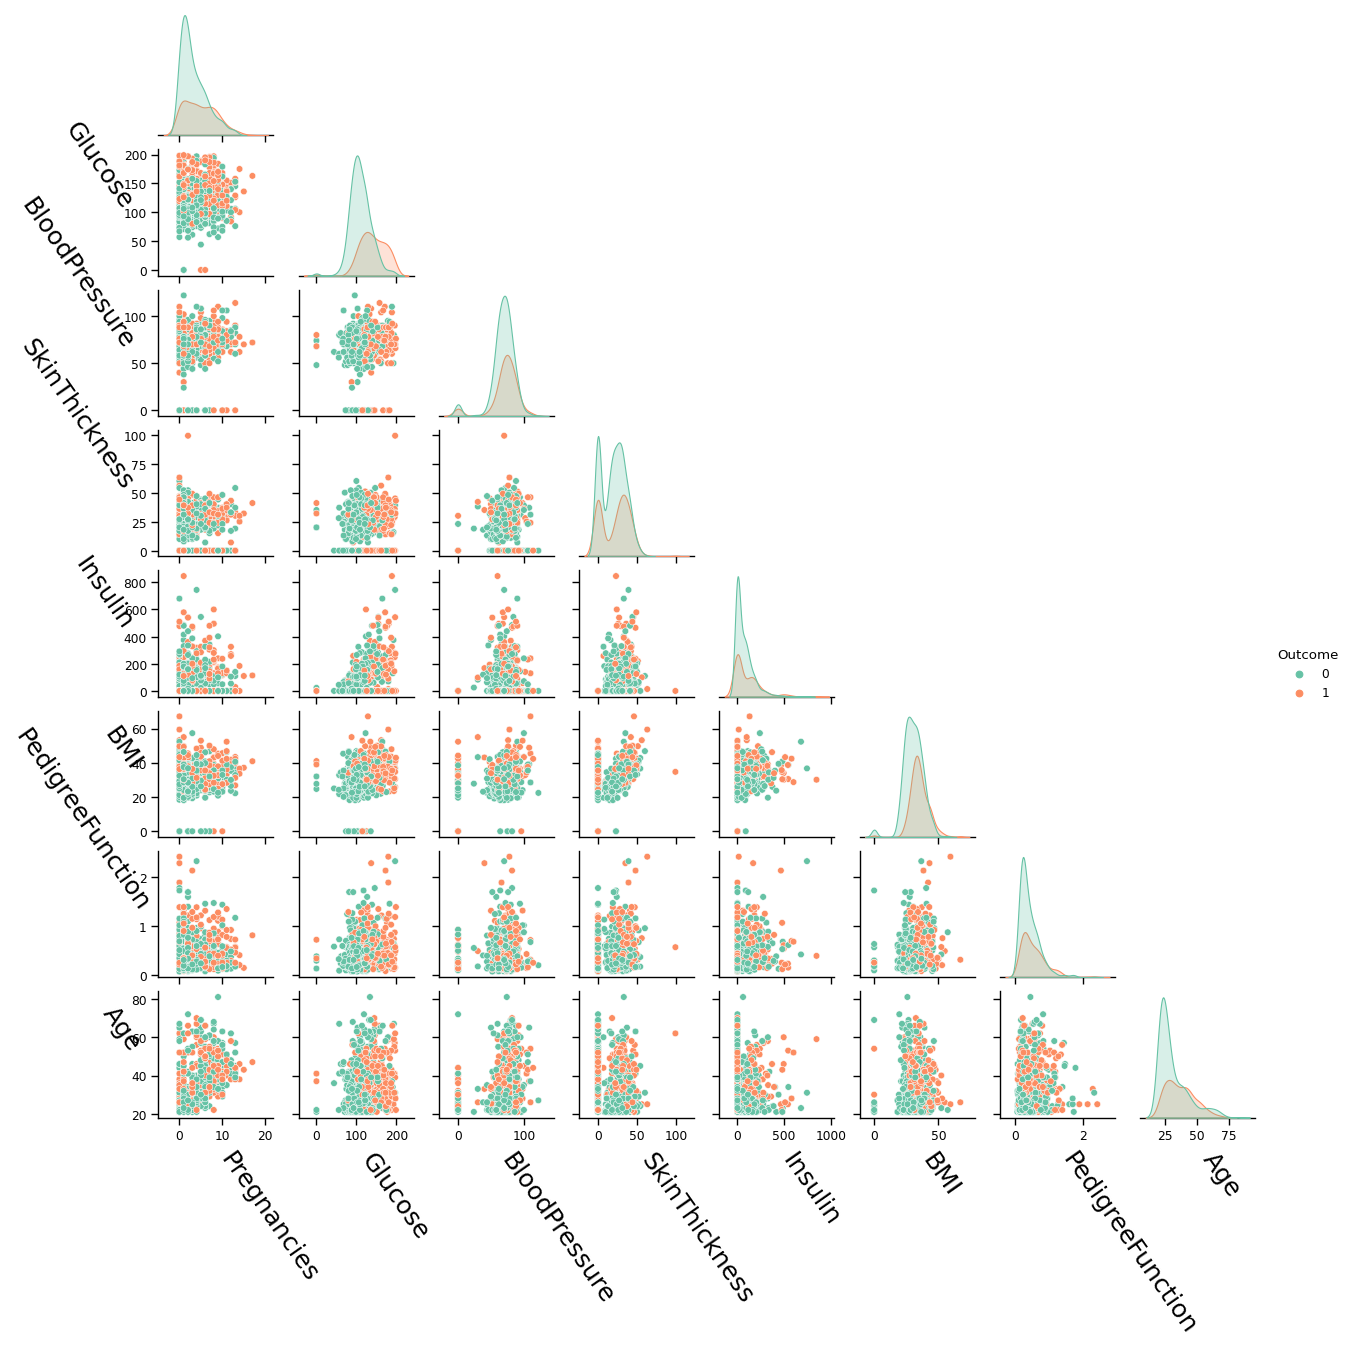

In [9]:
#set the axes label font size
sns.set_context("paper", rc={"axes.labelsize":18})
# includes a scatterplot of every pair of features in the data
# includes distribution plots of every feature
plot = sns.pairplot(data, hue = 'Outcome', palette= 'Set2', corner=True, height=1.5)
for ax in plot.axes.flatten():
    if ax:
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation = -55, horizontalalignment='left')
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation = -55, horizontalalignment='right')

Few values in various features that are zero  
These zeros in Glucose, Blood Pressure, Skin Thickness, Insulin, and BMI columns do not make much sense. These values were missing in the data and were replaced with zeros.

## Task 5: Missing value handling

### Plot the correlation matrix

<Axes: >

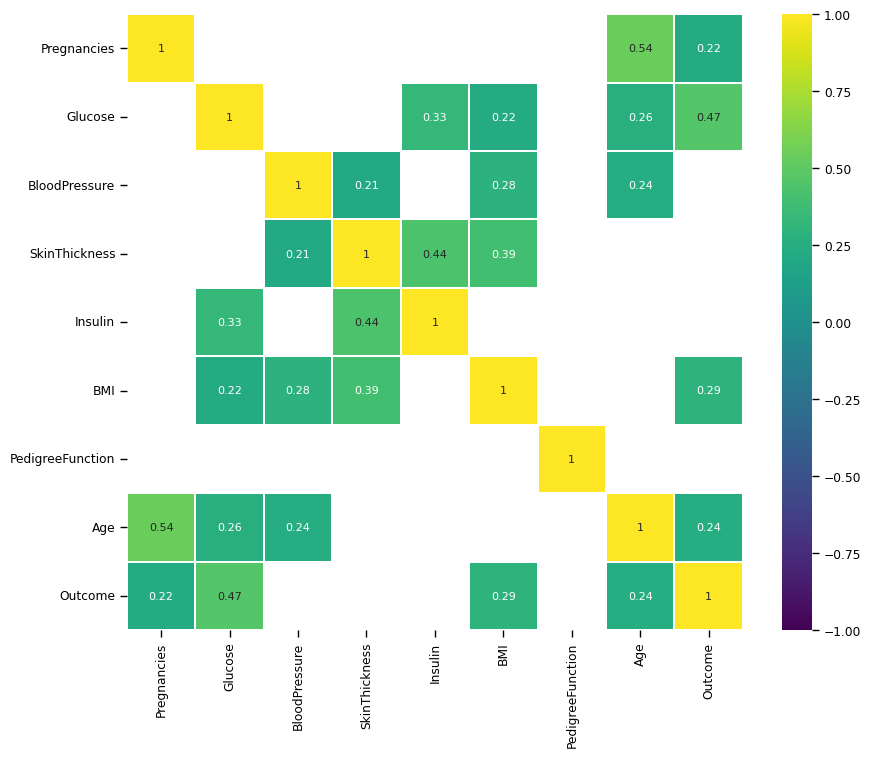

In [10]:
corr = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr[(corr >= 0.2) | (corr <= -0.2)], cmap='viridis',
            vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 8}, square=True)

### Get the number of missing values in each column

In [11]:
data_copy = data.copy()

for c in ['BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Glucose']:
  data_copy[c].replace(to_replace = 0, value = np.nan, inplace=True)

data_copy.isnull().sum()

Pregnancies           0
Glucose               5
BloodPressure        35
SkinThickness       227
Insulin             374
BMI                  11
PedigreeFunction      0
Age                   0
Outcome               0
dtype: int64

feature medians as the value for fixed value imputation because the data distributions are skewed.  
If the data distributions were normal, I would have used feature means.

### Impute feature medians in all columns that will not be predicted

In [12]:
for c in ['BloodPressure', 'BMI', 'SkinThickness', 'Insulin']:
      data[c].replace(to_replace = 0, value = data[c].median(), inplace=True)

### Use linear regression to predict the missing values in the column you chose for prediction

In [13]:
from sklearn import linear_model

for metric in ["Glucose"]:
    X = data[data[metric] != 0]
    X = X.drop(columns = [metric])
    y = data.loc[data[metric] != 0, metric]
    print("Training: ", metric, X.shape, y.shape)
    model = linear_model.LinearRegression()
    model.fit(X, y)
    X_miss = data[data[metric] == 0]
    X_miss = X_miss.drop(columns = [metric])
    print("missing values:", X_miss.shape)
    data.loc[data[metric] == 0, metric] = model.predict(X_miss)

Training:  Glucose (763, 8) (763,)
missing values: (5, 8)


Neural networks are better able to converge to the global optima if the data distribution is normal and has the same scale.

## Task 6: Handling Skewness and Feature Scaling

### Handling Skewness

In [14]:
for feature in ['SkinThickness', 'Insulin', 'BMI', 'PedigreeFunction', 'Age']:
    data[feature] = np.log(data[feature])

plot data distributions to see how they have changed after taking logarithm

### Creating Distribution Plots

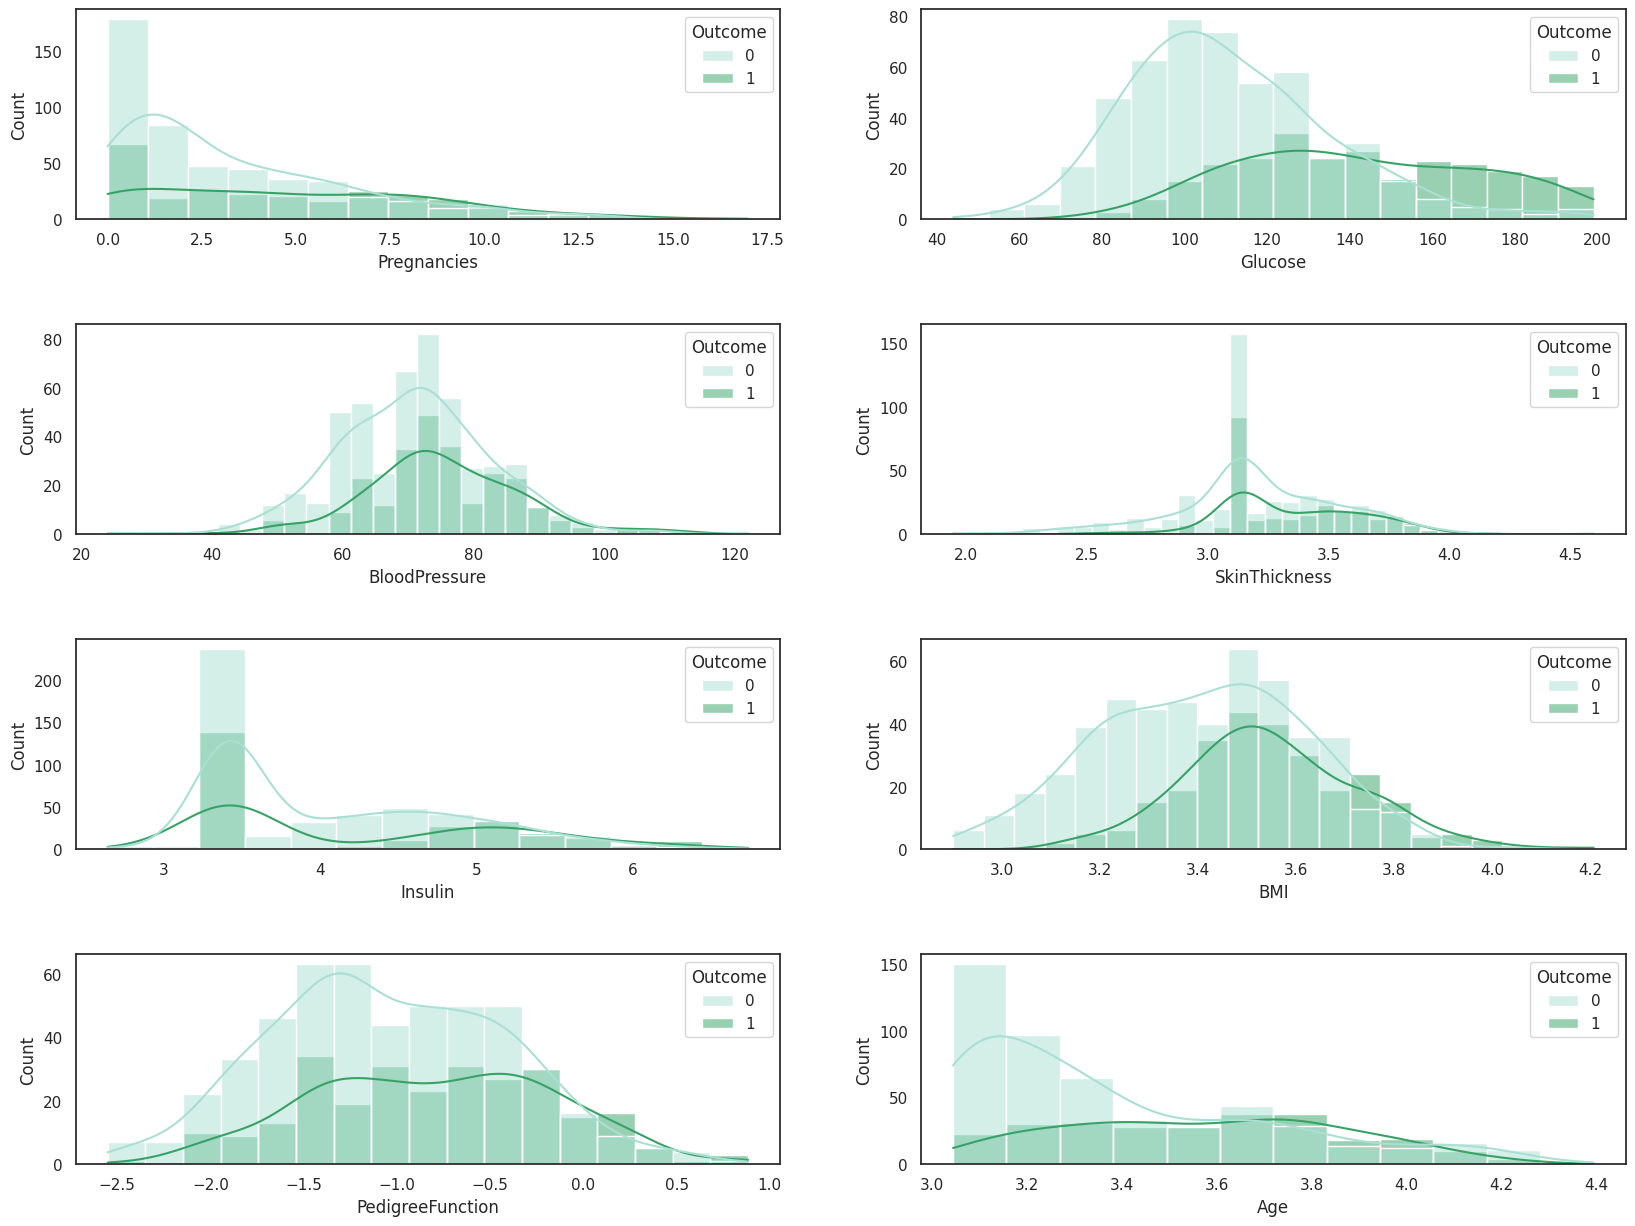

In [15]:
feature_names = list(data.columns)[:8]
rcParams['figure.figsize'] = 20,15
sns.set(font_scale = 1)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(4,2,i)
    sns.histplot(data=data, x=name, hue="Outcome",kde=True,palette="BuGn")
    i = i + 1

### Feature Scaling

In [16]:
scaler = StandardScaler()
train_data = data.to_numpy()
train_data[:, :8] = scaler.fit_transform(train_data[:, :8])

## Task 7: Feature Selection

In [17]:
X = train_data[:, [0, 1, 5, 7]]
Y = pd.get_dummies(train_data[:, 8])

## Task 8: Dataset Splitting

In [18]:
X_train, X_assess, Y_train, Y_assess = train_test_split(X, Y, test_size=0.4, random_state=10)
X_val, X_test, Y_val, Y_test = train_test_split(X_assess, Y_assess, test_size=0.5, random_state=10)
print("Y_train, Y_val, Y_test ", Y_train.shape, Y_val.shape, Y_test.shape )
print("X_train, X_val, X_test ", X_train.shape, X_val.shape, X_test.shape)

Y_train, Y_val, Y_test  (460, 2) (154, 2) (154, 2)
X_train, X_val, X_test  (460, 4) (154, 4) (154, 4)


## Task 9: Creating a neural network model

**Dense()** a method to add nodes to the model.  
This method accepts the following parameters:
* units: The number of units to add in the layer
* input_dim: The number of units in the input layer, i.e, the number of features in the training dataset. This is only to be used in the first layer.
* activation: Applies the specified activation function to the output

In [19]:
model = Sequential()
model.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='softmax'))

## Task 10: Model Training
### Compiling the model

Hyperparameters include training metrics such as learning rate and betas in optimizers, and architecture parameters such as numbers of layers in the neural network, and number of nodes in each layer.

In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training the model

In [21]:
h = model.fit(X_train, Y_train, epochs=40, validation_data=(X_val, Y_val), batch_size=32, verbose=1)

Epoch 1/40
15/15 [==============================] - 1s 22ms/step - loss: 0.6615 - accuracy: 0.6609 - val_loss: 0.6524 - val_accuracy: 0.6494
Epoch 2/40
15/15 [==============================] - 0s 6ms/step - loss: 0.6279 - accuracy: 0.6587 - val_loss: 0.6282 - val_accuracy: 0.6558
Epoch 3/40
15/15 [==============================] - 0s 7ms/step - loss: 0.6012 - accuracy: 0.6565 - val_loss: 0.6088 - val_accuracy: 0.6558
Epoch 4/40
15/15 [==============================] - 0s 5ms/step - loss: 0.5789 - accuracy: 0.6565 - val_loss: 0.5935 - val_accuracy: 0.6494
Epoch 5/40
15/15 [==============================] - 0s 6ms/step - loss: 0.5595 - accuracy: 0.6609 - val_loss: 0.5822 - val_accuracy: 0.6558
Epoch 6/40
15/15 [==============================] - 0s 5ms/step - loss: 0.5432 - accuracy: 0.6891 - val_loss: 0.5732 - val_accuracy: 0.6623
Epoch 7/40
15/15 [==============================] - 0s 6ms/step - loss: 0.5291 - accuracy: 0.7152 - val_loss: 0.5665 - val_accuracy: 0.6753
Epoch 8/40
15/15 [=

### Evaluating the model

In [22]:
scores = model.evaluate(X_test, Y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

5/5 [==============================] - 0s 3ms/step - loss: 0.4724 - accuracy: 0.7403
accuracy: 74.03%


### Saving the model

In [23]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

### Saving model weights

In [24]:
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Task 11: Printing the training curves

As the training proceeds, the validation loss continues to decrease, until it reaches a minimum. The validation loss usually increases after this point. It can decrease after this too;  
**Checkpointing** is used to save the best model weights when training a large deep neural network. I can use this retrain my entire network.

The training should be stopped when the validation loss reaches the minimum.

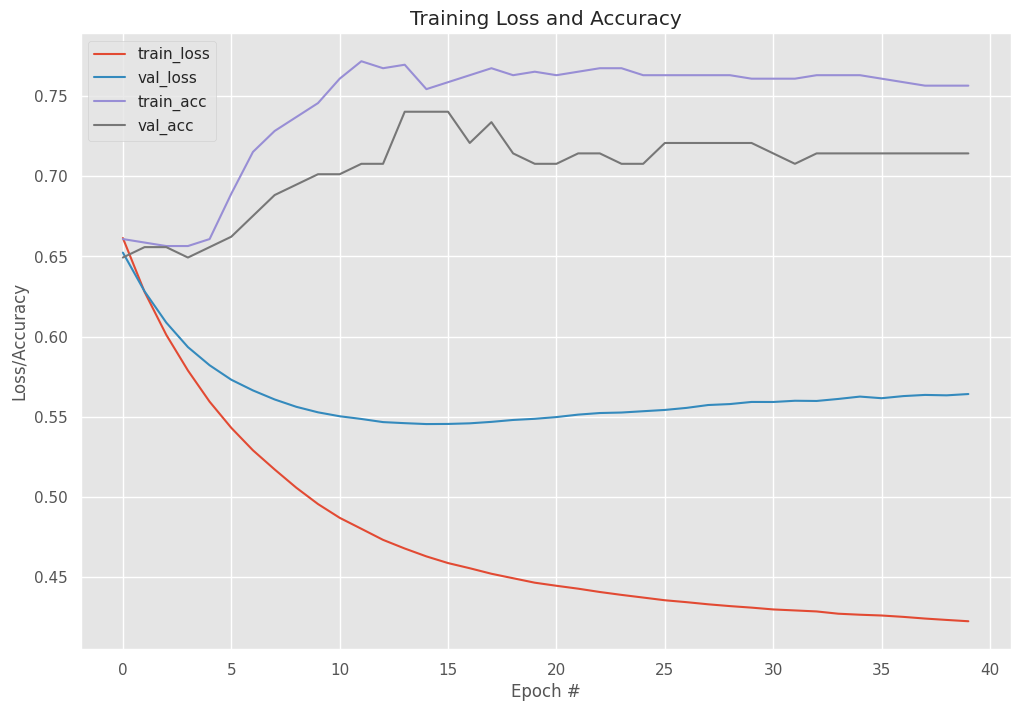

In [25]:
plt.rcParams["figure.figsize"] = (12,8)
N = np.arange(0, 40)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, h.history["loss"], label="train_loss")
plt.plot(N, h.history["val_loss"], label="val_loss")
plt.plot(N, h.history['accuracy'], label="train_acc")
plt.plot(N, h.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

## Task 12: Confusion Matrix
### Test set predictions

The confusion matrix shows a comparison of the actual classes with the predicted classes.

The model must have a sufficient number of the predictions in all of the classes. If the model always predicts true, and there is a high class imbalance, it is possible to have a good accuracy–even though the model always predicts one class.

In [26]:
actuals = np.argmax([Y_test.T], axis=1)[0]
Y_predicted = model.predict(X_test)
classes= np.argmax(Y_predicted,axis=1)

5/5 [==============================] - 0s 3ms/step


### Creating and displaying the confusion matrix

Text(16.25, 0.5, 'True')

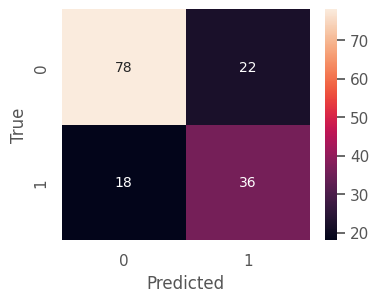

In [27]:
cm = confusion_matrix(actuals, classes)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

## Task 13: Compute classification metrics

In [28]:
target_names = ['Diabetes', "No-Diabetes"]
print(classification_report(actuals, classes, target_names=target_names))

              precision    recall  f1-score   support

    Diabetes       0.81      0.78      0.80       100
 No-Diabetes       0.62      0.67      0.64        54

    accuracy                           0.74       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.75      0.74      0.74       154

